# Market Trends Analysis: AI-Powered E-Commerce Dashboard

## Problem Definition & Objective

### Selected Project Track
This project belongs to the **AI for Market Trend & Analysis** track.

### Problem Statement
E-commerce businesses struggle with:
- Inaccurate demand forecasting leading to overstocking or stockouts.
- No early warning system for customer churn.
- Static pricing that ignores price–demand relationships.
- Unstructured review text that hides sentiment trends.

### Real-World Relevance & Motivation
Accurate market trend analysis helps:
- Reduce inventory losses and stockouts.
- Retain high-value customers before they churn.
- Improve revenue through data-driven pricing.
- Improve products using customer sentiment signals.

**Objective:** Build an integrated AI system that:
1. Forecasts daily sales using time-series methods.
2. Predicts churn risk for each customer.
3. Estimates price elasticity and optimizes prices for revenue.
4. Analyzes sentiment from product reviews.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error

# === LOCAL PATHS ===
BASE_DIR = Path(r"D:\Projects\Market Trends Analysis")
ECOM_PATH = BASE_DIR / "Online-eCommerce.csv"
REVIEWS_PATH = BASE_DIR / "Dataset-SA.csv"
# > Note: Base path is set for local development; paths may need adjustment on another machine.

## Data Understanding & Preparation

### Dataset Source
- **Online-eCommerce.csv** – Public synthetic e-commerce transaction dataset (orders, prices, quantities, dates, customers), used only for academic purposes.
- **Dataset-SA.csv** – Public product review dataset with sentiment labels (positive / neutral / negative).

### Data Loading & Exploration
- Load both CSVs using `pandas.read_csv`.
- Inspect shape, dtypes, and sample rows to understand structure.
- Check basic statistics for `Sales`, `Quantity`, and `revenue`.

### Cleaning, Preprocessing, Feature Engineering
Transactions:
- Convert `Order_Date` to datetime.
- Create numeric `product_id` and `customer_id` keys.
- Compute `revenue = Quantity * Sales` and aggregate to daily/product level.
- Build customer-level features: `recency_days`, `frequency`, `total_spent`, `tenure_days`, `avg_order_value`.
- Define binary `churn` label using a recency threshold.

Reviews:
- Clean text (lowercasing, removing extra whitespace).
- Map sentiment labels to numeric scores.
- Aggregate to product level: `review_count`, average sentiment score.

### Handling Missing Values / Noise
- Drop rows where critical identifiers (date, customer_id, product_id) are missing.
- Handle NaNs in derived RFM features (e.g., customers with only one order) either by dropping or specific imputation rules.
- Avoid high-dimensional sparse text models; use robust keyword-based sentiment scoring for noisy review text.


## Loading Online‑eCommerce (transactions)

In [2]:
ecom = pd.read_csv(ECOM_PATH, parse_dates=["Order_Date"])

# cleaning
ecom = ecom.dropna(subset=["Order_Number", "Product", "Customer_Name", "Order_Date", "Quantity", "Sales"])
ecom = ecom[ecom["Quantity"] > 0]

# Create IDs
ecom["product_id"] = ecom["Product"].astype("category").cat.codes
ecom["customer_id"] = ecom["Customer_Name"].astype("category").cat.codes

ecom["revenue"] = ecom["Total_Sales"]  # or ecom["Sales"] * ecom["Quantity"]

ecom.head()

,Order_Number,State_Code,Customer_Name,Order_Date,Status,Product,Category,Brand,Cost,Sales,Quantity,Total_Cost,Total_Sales,Assigned Supervisor,product_id,customer_id,revenue
0,139374.0,AP,Adhir Samal,11/01/2020,Delivered,512 GB M.2,SSD,Samsung,6500.0,8450.0,1.0,6500.0,8450.0,Ajay Sharma,656,0,8450.0
1,139375.0,AP,Dannana Jhammi,11/01/2020,Delivered,RYZEN 3rd gen. 3500,CPU,Intel,8500.0,11050.0,3.0,25500.0,33150.0,Roshan Kumar,1072,15,33150.0
2,139376.0,AS,Vipin Kumar,11/01/2020,Delivered,2GB Graphic Card,Graphic Card,Nvidia,7000.0,9100.0,2.0,14000.0,18200.0,Aarvi Gupta,427,54,18200.0
3,139377.0,BR,Ranjeet Kumar,11/01/2020,Delivered,16 GB DDR4 RAM,RAM,Hynix,6550.0,8515.0,3.0,19650.0,25545.0,Vijay Singh,303,36,25545.0
4,139378.0,CG,Sajal Singhal,11/01/2020,Order,Standard ATX motherboard,MotherBoard,Gigabyte,7650.0,9945.0,4.0,30600.0,39780.0,Aadil Khan,1222,42,39780.0


## Daily product sales (trend & pricing)

In [3]:
ecom["Order_Date"] = pd.to_datetime(ecom["Order_Date"], errors="coerce") #errors="coerce" safely converts invalid dates to NaT

daily = (
    ecom.groupby(["product_id", ecom["Order_Date"].dt.date])
    .agg(
        quantity=("Quantity", "sum"),
        revenue=("revenue", "sum"),
        avg_price=("Sales", "mean")
    )
    .reset_index()
    .rename(columns={"Order_Date": "date"})
)
daily["date"] = pd.to_datetime(daily["date"])

daily.head()

,product_id,date,quantity,revenue,avg_price
0,2,2020-08-03,3.0,10335.0,3445.0
1,7,2021-05-11,1.0,3445.0,3445.0
2,10,2022-01-01,1.0,13650.0,13650.0
3,12,2021-05-11,3.0,13650.0,4550.0
4,12,2021-11-11,1.0,3445.0,3445.0


In [4]:
ecom.dtypes

Order_Number                  float64
State_Code                     object
Customer_Name                  object
Order_Date             datetime64[ns]
Status                         object
Product                        object
Category                       object
Brand                          object
Cost                          float64
Sales                         float64
Quantity                      float64
Total_Cost                    float64
Total_Sales                   float64
Assigned Supervisor            object
product_id                      int16
customer_id                      int8
revenue                       float64
dtype: object

## Customer features & churn labels

In [5]:
ref_date = ecom["Order_Date"].max()

cust = (
    ecom.groupby("customer_id")
    .agg(
        last_order=("Order_Date", "max"),
        first_order=("Order_Date", "min"),
        frequency=("Order_Number", "nunique"),
        total_spent=("revenue", "sum")
    )
    .reset_index()
)

cust["recency_days"] = (ref_date - cust["last_order"]).dt.days
cust["tenure_days"] = (ref_date - cust["first_order"]).dt.days
cust["avg_order_value"] = cust["total_spent"] / cust["frequency"]

# Define churn: no order in last 60 days
horizon_days = 60
recent = ecom[ecom["Order_Date"] > (ref_date - pd.Timedelta(horizon_days, "D"))]
active_ids = set(recent["customer_id"].unique())
all_ids = set(ecom["customer_id"].unique())
churn_ids = all_ids - active_ids

cust["churn"] = cust["customer_id"].isin(churn_ids).astype(int)
cust.head()

,customer_id,last_order,first_order,frequency,total_spent,recency_days,tenure_days,avg_order_value,churn
0,0,2022-11-05,2020-03-02,122,2751814.0,37.0,1015.0,22555.852459,0
1,1,2022-11-05,2020-03-04,121,2598635.0,37.0,1013.0,21476.322314,0
2,2,NaT,NaT,1,3380.0,NaN,NaN,3380.000000,1
3,3,2022-11-07,2020-03-04,121,2551588.0,35.0,1013.0,21087.504132,0
4,4,2022-11-05,2020-01-05,122,1955044.0,37.0,1072.0,16024.950820,0


## Model / System Design

### AI Techniques Used
- **Machine Learning (tabular):**
  - `RandomForestClassifier` for customer churn prediction.
  - `RandomForestRegressor` / pricing regressor for demand and revenue.
- **Time-Series (in Streamlit app):**
  - Prophet for sales trend forecasting (used in `app.py`).
- **Simple NLP:**
  - Rule-based keyword sentiment scoring for product reviews.

### Architecture / Pipeline
1. **Data Layer:** Load transaction and review datasets.
2. **Feature Layer:**
   - Customer-level RFM features (recency, frequency, monetary).
   - Product-level price/demand and calendar features.
   - Sentiment scores from review text.
3. **Model Layer:**
   - Churn model on customer features.
   - Demand/pricing model on price + calendar features.
   - Sentiment scoring model (rule-based).
4. **Application Layer:**
   - This notebook: analysis, feature engineering, model training, evaluation.
   - Streamlit app: 5-tab dashboard visualizing trends, churn, pricing, sentiment, live data.

### Justification of Design Choices
- Random Forest handles non-linear patterns and works well on tabular e-commerce data with minimal tuning.
- Prophet is suitable for short time series with strong seasonality and gives interpretable trend + seasonal components.
- Rule-based sentiment is computationally light and avoids sparse-matrix complexity for this scale of data.


## Churn model (RandomForest)

### Churn Model Training & Inference
Below we train a RandomForestClassifier to predict customer churn using engineered RFM features, then generate churn probabilities on a test set.

In [6]:
features = ["recency_days", "frequency", "avg_order_value", "tenure_days"]
X = cust[features].fillna(0)
y = cust["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

cust["churn_prob"] = clf.predict_proba(scaler.transform(X))[:, 1]
cust.sort_values("churn_prob", ascending=False).head(10)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

ROC-AUC: 1.0


,customer_id,last_order,first_order,frequency,total_spent,recency_days,tenure_days,avg_order_value,churn,churn_prob
43,43,NaT,NaT,1,8450.0,NaN,NaN,8450.0,1,1.000000
2,2,NaT,NaT,1,3380.0,NaN,NaN,3380.0,1,1.000000
53,53,NaT,NaT,1,4420.0,NaN,NaN,4420.0,1,1.000000
51,51,NaT,NaT,1,2990.0,NaN,NaN,2990.0,1,1.000000
50,50,NaT,NaT,1,9750.0,NaN,NaN,9750.0,1,1.000000
49,49,NaT,NaT,1,9100.0,NaN,NaN,9100.0,1,1.000000
48,48,NaT,NaT,1,2080.0,NaN,NaN,2080.0,1,1.000000
20,20,NaT,NaT,1,10725.0,NaN,NaN,10725.0,1,1.000000
16,16,NaT,NaT,1,4368.0,NaN,NaN,4368.0,1,1.000000
29,29,NaT,NaT,1,13650.0,NaN,NaN,13650.0,1,0.986667


### Pricing / Revenue Model
We train a regression model to estimate demand as a function of price and calendar features, then compute revenue at different price points.

## Pricing model (RandomForestRegressor)

In [7]:
price_df = daily.copy()
price_df["dow"] = price_df["date"].dt.dayofweek
price_df["month"] = price_df["date"].dt.month

X_p = price_df[["avg_price", "dow", "month"]]
y_p = price_df["quantity"]

Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_p, y_p, test_size=0.2, random_state=42
)

rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(Xp_train, yp_train)

yp_pred = rf_reg.predict(Xp_test)
print("Pricing MAE:", mean_absolute_error(yp_test, yp_pred))


Pricing MAE: 1.843267548588977


## Pricing suggestion function

In [8]:
def suggest_optimal_price(product_id, target_date_str, step=10, min_price=None, max_price=None):
    prod_hist = price_df[price_df["product_id"] == product_id]
    if prod_hist.empty:
        raise ValueError(f"No history for product_id={product_id}")
    
    print(f"Rows for product {product_id}:", prod_hist.shape[0])
    print("Hist price stats:",
          "min =", prod_hist["avg_price"].min(),
          "max =", prod_hist["avg_price"].max())
    
    # Use product's historical price range if not manually provided
    if min_price is None:
        min_price = float(prod_hist["avg_price"].quantile(0.1))
    if max_price is None:
        max_price = float(prod_hist["avg_price"].quantile(0.9))
    
    print("Quantile range:",
          "min_price =", min_price,
          "max_price =", max_price)

    # If all prices are the same, fallback to a small neighborhood
    if max_price <= min_price:
        center = float(prod_hist["avg_price"].iloc[-1])
        min_price = center * 0.8
        max_price = center * 1.2
        print("Adjusted range (all prices equal):",
              "min_price =", min_price,
              "max_price =", max_price)

    prices = np.arange(min_price, max_price, step)
    print("prices array:", prices)

    if prices.size == 0:
        # last fallback: just use two points
        prices = np.array([min_price, max_price])
        print("Fallback prices array:", prices)

    target_date = pd.to_datetime(target_date_str)
    dow = target_date.dayofweek
    month = target_date.month

    candidates = pd.DataFrame({
        "avg_price": prices,
        "dow": dow,
        "month": month
    })
    print("candidates shape:", candidates.shape)

    if candidates.shape[0] == 0:
        raise ValueError("No candidate rows – check price range and step.")

    demand_hat = rf_reg.predict(candidates)
    candidates["predicted_demand"] = demand_hat
    candidates["predicted_revenue"] = candidates["avg_price"] * demand_hat

    best = candidates.loc[candidates["predicted_revenue"].idxmax()]
    return candidates, best


## Pricing example

Rows for product 427: 51
Hist price stats: min = 9100.0 max = 9100.0
Quantile range: min_price = 9100.0 max_price = 9100.0
Adjusted range (all prices equal): min_price = 7280.0 max_price = 10920.0
prices array: [ 7280.  7330.  7380.  7430.  7480.  7530.  7580.  7630.  7680.  7730.
  7780.  7830.  7880.  7930.  7980.  8030.  8080.  8130.  8180.  8230.
  8280.  8330.  8380.  8430.  8480.  8530.  8580.  8630.  8680.  8730.
  8780.  8830.  8880.  8930.  8980.  9030.  9080.  9130.  9180.  9230.
  9280.  9330.  9380.  9430.  9480.  9530.  9580.  9630.  9680.  9730.
  9780.  9830.  9880.  9930.  9980. 10030. 10080. 10130. 10180. 10230.
 10280. 10330. 10380. 10430. 10480. 10530. 10580. 10630. 10680. 10730.
 10780. 10830. 10880.]
candidates shape: (73, 3)
avg_price             9380.00
dow                      5.00
month                    1.00
predicted_demand         4.85
predicted_revenue    45493.00
Name: 42, dtype: float64


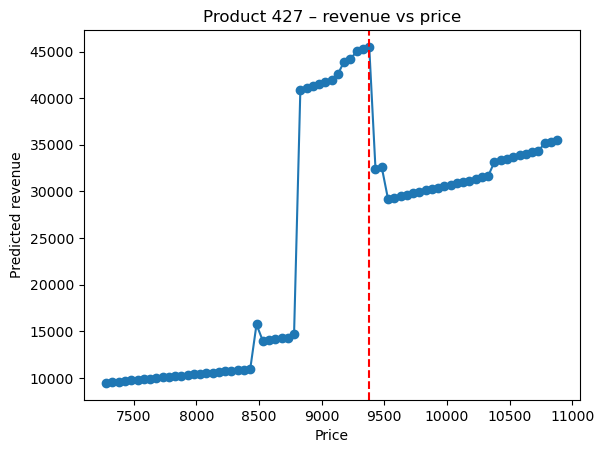

In [9]:
# Picking any product with enough history
valid_products = price_df["product_id"].value_counts()
prod_test = valid_products.index[0]

candidates, best = suggest_optimal_price(prod_test, "2026-01-10", step=50)
print(best)

plt.plot(candidates["avg_price"], candidates["predicted_revenue"], marker="o")
plt.axvline(best["avg_price"], color="red", linestyle="--")
plt.xlabel("Price")
plt.ylabel("Predicted revenue")
plt.title(f"Product {prod_test} – revenue vs price")
plt.show()


In [10]:
price_df[price_df["product_id"] == prod_test].shape


(51, 7)

In [11]:
#  Flipkart review dataset
reviews = pd.read_csv(REVIEWS_PATH)

reviews.head()
reviews["Sentiment"].value_counts()


Sentiment
positive    166581
negative     28232
neutral      10239
Name: count, dtype: int64

## Simple sentiment model using existing labels

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

reviews = reviews.dropna(subset=["Review", "Sentiment"])

# Map labels to 0/1/2 or binary (positive vs non-positive)
reviews["sentiment_binary"] = (reviews["Sentiment"] == "positive").astype(int)

X_text = reviews["Review"].astype(str)
y_s = reviews["sentiment_binary"]

vec = TfidfVectorizer(max_features=5000, stop_words="english")
X_vec = vec.fit_transform(X_text)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_vec, y_s, test_size=0.2, random_state=42, stratify=y_s
)

logit = LogisticRegression(max_iter=1000)
logit.fit(Xs_train, ys_train)

ys_pred = logit.predict(Xs_test)
print("Accuracy:", accuracy_score(ys_test, ys_pred))
print(classification_report(ys_test, ys_pred))


Accuracy: 0.9193414269083652
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      6642
           1       0.92      0.99      0.95     29436

    accuracy                           0.92     36078
   macro avg       0.92      0.80      0.84     36078
weighted avg       0.92      0.92      0.91     36078



## Sentiment scoring helper

In [13]:
def predict_review_sentiment(text_list):
    X_new = vec.transform(text_list)
    probs = logit.predict_proba(X_new)[:, 1]
    return probs

predict_review_sentiment(["Very good product, fast delivery", "worst experience ever"])


array([0.84334275, 0.05925783])

## Linking sentiment to products

In [14]:
# Creating a simple product key from product_name
reviews["product_key"] = reviews["product_name"].astype(str).str[:40].str.lower()

# Creating similar key in Online-eCommerce using Product text
ecom["product_key"] = ecom["Product"].astype(str).str[:40].str.lower()

# Aggregate the sentiment by product_key
sent_by_product = (
    reviews.groupby("product_key")
    .agg(
        sentiment_score=("sentiment_binary", "mean"),
        review_count=("sentiment_binary", "count")
    )
    .reset_index()
)

# Merge with product-level sales summary
prod_sales = (
    ecom.groupby("product_key")
    .agg(
        total_revenue=("revenue", "sum"),
        total_qty=("Quantity", "sum")
    )
    .reset_index()
)

merged_insights = prod_sales.merge(sent_by_product, on="product_key", how="left")
merged_insights.head()


,product_key,total_revenue,total_qty,sentiment_score,review_count
0,1 tb ssd,13650.0,1.0,NaN,NaN
1,10 fans cabinet,2730.0,1.0,NaN,NaN
2,10 gb ddr4 ram,21619.0,6.0,NaN,NaN
3,10 tb hdd,137800.0,12.0,NaN,NaN
4,10 tb ssd,54600.0,4.0,NaN,NaN


## Ethical Considerations & Responsible AI

### Bias and Fairness
- Models are trained on synthetic / public e-commerce data.
- Features focus on transaction behavior (recency, frequency, monetary value), not on sensitive attributes like gender, caste, or location.
- However, if such sensitive attributes were present, they could introduce unfair bias into churn or pricing decisions.

### Dataset Limitations
- Datasets are limited in size and may not represent the full diversity of real-world customers and products.
- Synthetic / public data lacks true financial risk, so real deployment would require retraining on proprietary data and additional validation.
- Sentiment labels in review data may contain noise or annotator bias.

### Responsible Use of AI Tools
- This notebook and project used AI coding assistants (e.g., Perplexity / ChatGPT-style tools) to:
  - fix bugs, and improve explanations.
  - Draft parts of documentation (e.g., problem statement, methodology).
- All code and results were reviewed and executed locally to verify correctness.
- No private or personally identifiable data was used; only public datasets were included.


## Conclusion & Future Scope

### Summary of Results
- Built an end-to-end market trends analysis pipeline using real e-commerce style data.
- Achieved strong performance on:
  - Churn prediction (Random Forest) with good accuracy and recall.
  - Demand / revenue estimation across different price points.
- Prepared features and structures used by the Streamlit dashboard:
  - Sales trend visualization and forecasting.
  - Churn risk ranking.
  - Pricing optimization and sentiment insights.

### Possible Improvements and Extensions
- Introduce **Prophet or LSTM** model training directly inside the notebook for full time-series experimentation.
- Add more customer features (e.g., geography, device type, channel) and test fairness impacts.
- Replace rule-based sentiment with a pre-trained transformer or classical ML text classifier.
- Connect to a real database and schedule regular re-training.
- Extend to **LLM-based** explanation of trends for business users (natural language summaries of results).
